# NOTE: This does not have a test or validation dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
image_shape = (224, 224)

In [3]:
# Now use some other available data
# Download it to keras 
data_root = tf.keras.utils.get_file(
    'flower_photos', 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True
)
# Use an image generator to build these images
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
img_data = img_generator.flow_from_directory(str(data_root), target_size=image_shape)
for img_batch, label_batch in img_data:
    print(img_batch.shape)
    print(label_batch.shape)
    break

Found 3670 images belonging to 5 classes.
(32, 224, 224, 3)
(32, 5)


In [8]:
# include_top = False removes the classifier layer from the MobileNet
headless_model = tf.keras.applications.MobileNet(
    input_shape=image_shape+(3,),
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    include_top=False,
    weights='imagenet',
)
# Lock the weights for the convolution
headless_model.trainable = False

# Add the fully connected dense layers after the convolution has been don
model = tf.keras.Sequential([
    headless_model,
    # I think this layer is needed due to the Mobile net feature shape (but I may be wrong)
    # Guide showed [32, 1280], we got [32, 7, 7, 1024]
    # Tested this and without the GlobalAveragePooling layer it will not work
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(img_data.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
# features_img_batch = headless_model(img_batch)
# features_img_batch.shape

In [9]:
model.fit(img_data, epochs=10)

Epoch 1/10
 19/115 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.4593 - loss: 1.5081

KeyboardInterrupt: 

In [10]:
model.save('../keras_models/flower_global_avg_pooling.keras')
# model = tf.keras.models.load_model('../keras_models/flower_global_avg_pooling.keras')

In [11]:
class_names = (['Daisy', 'Dandelion', 'Roses', 'Sunflower', 'Tulips'])

In [12]:
y_pred = model.predict(img_batch)
y_pred_ids = np.argmax(y_pred, axis=-1)
y_pred_classes = [class_names[idx] for idx in y_pred_ids]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


In [13]:
label_ids = np.argmax(label_batch, axis=-1)

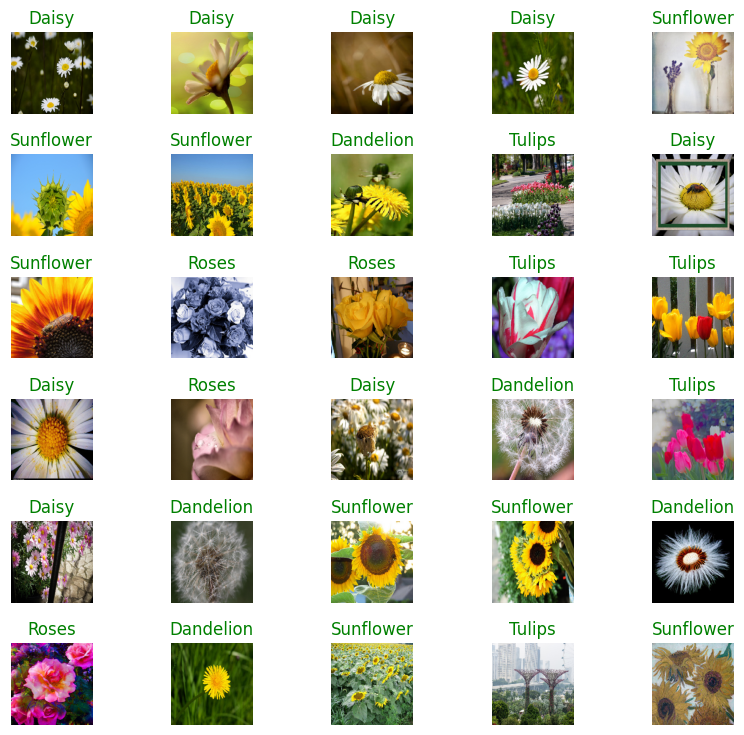

In [14]:
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)
for i in range(30):
    plt.subplot(6, 5, i+1)
    plt.imshow(img_batch[i])
    if y_pred_ids[i] == label_ids[i]:
        val_color = 'green'
    else:
        val_color = 'red'
    plt.title(y_pred_classes[i].title(), color=val_color)
    plt.axis('off')